In [1]:
import numpy as np
import matplotlib.pyplot as mp
import matplotlib.ticker as tick
import control
import scipy.signal as sig
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
mp.style.use("seaborn")
mp.rcParams["font.family"] = "serif"
mp.rcParams["text.usetex"] = True
mp.rcParams["figure.figsize"] = (5*16/9, 5)
mp.rcParams["figure.dpi"] = 100

# 1. Lead compensator

In [47]:
class LeadCompensator:
    
    def __init__(self, w):
        self.w = w
        self.s = 1j*w
        
    def initTransferFunc(self, G):
        self.G = G
        
    def initNegativeFeedback(self, gain):
        self.k = gain
        self.H = self.G(self.s)/(1 + self.k*self.G(self.s))
        self.magnitude = 20*np.log10(self.H)
        self.phase = np.degrees(np.arctan2(self.H.imag, self.H.real))
        
    def BodePlot(self, save=False, savename=None):
        fig = mp.figure(figsize=(5*16/9, 5*1.25))
        
        ax = fig.add_subplot(211)
        ax.plot(self.w, self.magnitude)
        ax.set_xscale("log")
        ax.grid(True, which="both")
        ax.set_ylabel("magnitude (dB)")
        ax.set_xlim(self.w.min(), self.w.max())
        ax.set_ylim(self.magnitude.min(), self.magnitude.max()+2)
        ax.xaxis.set_major_formatter(tick.NullFormatter())
        
        ax = fig.add_subplot(212)
        ax.plot(self.w, self.phase)
        ax.set_xscale("log")
        ax.grid(True, which="both")
        ax.set_xlabel("angular frequency (rad/s)")
        ax.set_ylabel("phase (deg)")
        ax.set_xlim(self.w.min(), self.w.max())
        ax.set_ylim(self.phase.min()-1, self.phase.max()+1)
        
        mp.tight_layout()
        if save:
            mp.savefig(savename, dpi=300, bbox_inches="tight")
        mp.show()
        
    def initDesired(self, percent_overshoot, Tp):
        self.zeta = -np.log(percent_overshoot)/np.sqrt(np.pi**2 + \
                                            np.log(percent_overshoot)**2)
        self.wn = np.pi/(Tp * np.sqrt(1 - self.zeta**2))
        self.sd = -self.zeta*self.wn + 1j*self.wn*np.sqrt(1 - self.zeta**2)
        self.Gsd = self.G(self.sd)
        self.phiGsd = np.arctan2(self.Gsd.imag, self.Gsd.real)
        self.phid = np.pi - self.phiGsd
        
    def initCompensator(self):
        self.alpha = np.arctan2(np.sqrt(1 - self.zeta**2), self.zeta)
        self.zc = -self.wn*np.sqrt(1 - self.zeta**2) * \
                    np.tan((self.alpha - self.phid)/2) - self.zeta*self.wn
        self.pc = -self.wn*np.sqrt(1 - self.zeta**2) * \
                    np.tan((self.alpha + self.phid)/2) - self.zeta*self.wn
        self.K = 1/abs(self.Gsd*(self.sd + self.zc)/(self.sd + self.pc))

In [48]:
dt = np.arange(0, 10.01, 0.01)
tf = control.tf([3], [2, 5, 6])
tf_fb = control.feedback(tf, 1)
dt, y = control.step_response(tf_fb, dt)

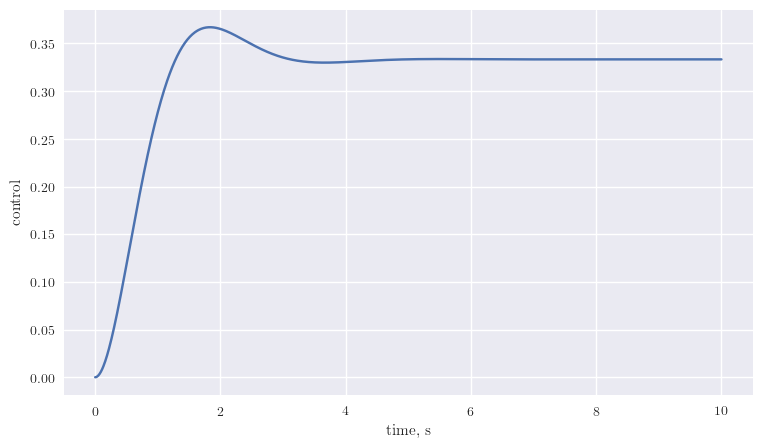

%OS = 10.11
peak time = 1.83


In [49]:
mp.plot(dt, y)
mp.xlabel("time, s")
mp.ylabel("control")
mp.savefig("LE3_gs_step.png", dpi=300, bbox_inches="tight")
mp.show()

print("%OS = {0:.2f}".format(((y.max() - y[-1])/y[-1])*100))
print("peak time = {0:.2f}".format(dt[np.argmax(y)]))

In [50]:
def G(s):
    return 3/(2*s**2 + 5*s + 6)

w = np.logspace(-1, 2, 500)
sys = LeadCompensator(w)
sys.initTransferFunc(G)
sys.initNegativeFeedback(1)
sys.initDesired(0.10, 0.1)
sys.initCompensator()

In [52]:
dt = np.arange(0, 10.01, 0.01)
tf = control.tf([3], [2, 5, 6])
tf_fb = control.feedback(tf, 1)
lc = control.tf([1, -sys.zc], [1, -sys.pc])
gain = sys.K
tf_pluslc = control.series(gain, lc, tf)
tf_lcfb = control.feedback(tf_pluslc, 1)
dt, y = control.step_response(tf_lcfb, dt)

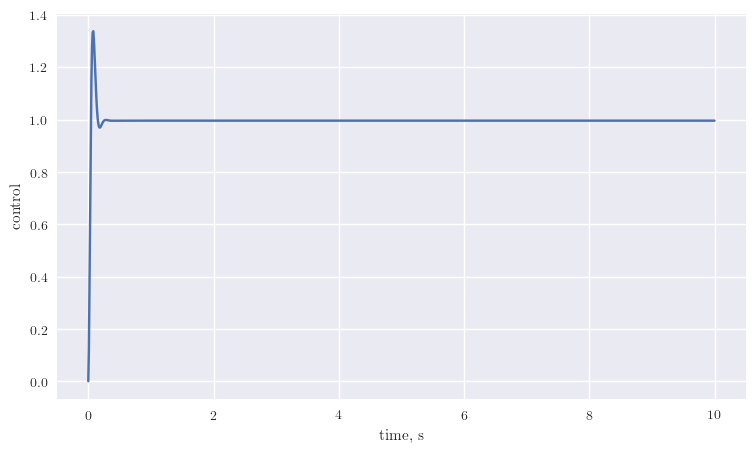

%OS = 33.75
peak time = 0.08


In [53]:
mp.plot(dt, y)
mp.xlabel("time, s")
mp.ylabel("control")
mp.savefig("LE3_lc_step.png", dpi=300, bbox_inches="tight")
mp.show()

print("%OS = {0:.2f}".format(((y.max() - 1)/1)*100))
print("peak time = {0:.2f}".format(dt[np.argmax(y)]))

# 2. Describing Function

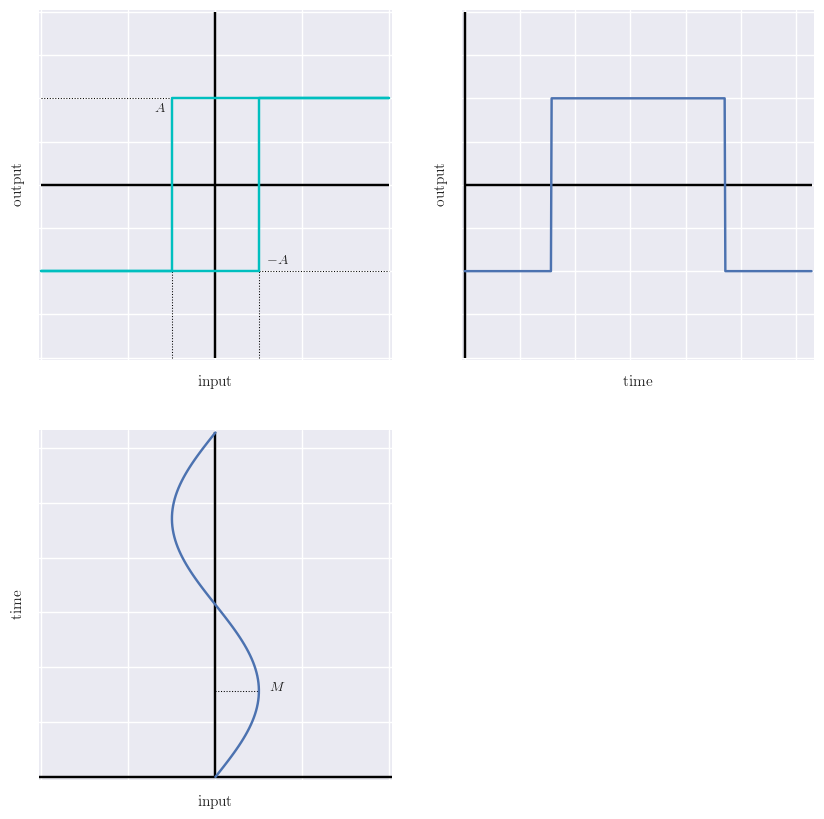

In [141]:
fig = mp.figure(figsize=(5*2, 5*2))

ax = fig.add_subplot(221)
xtf1 = np.concatenate((np.linspace(-4, 1, 50), np.linspace(1, 4, 50)))
xtf2 = np.concatenate((np.linspace(-4, -1, 50), np.linspace(-1, 4, 50)))
ytf = np.concatenate((np.ones(50)*-2, np.ones(50)*2))
ax.plot(xtf1, ytf, "c-")
ax.plot(xtf2, ytf, "c-")
ax.set_xlabel("input")
ax.set_ylabel("output")
ax.text(1.2, -1.8, "$-A$")
ax.text(-1.4, 1.7, "$A$")
ax.hlines(-2, 1, 4, linestyle=":", linewidth=0.75)
ax.hlines(2, -4, -1, linestyle=":", linewidth=0.75)
ax.vlines(1, -4, -2, linestyle=":", linewidth=0.75)
ax.vlines(-1, -4, -2, linestyle=":", linewidth=0.75)
ax.hlines(0, xtf1.min(), xtf1.max())
ax.vlines(0, -4, 4)
ax.set_xlim(-4.05, 4.05)
ax.set_ylim(-4.05, 4.05)
ax.xaxis.set_major_formatter(tick.NullFormatter())
ax.yaxis.set_major_formatter(tick.NullFormatter())

ax = fig.add_subplot(222)
xout = np.linspace(0, 2*np.pi, 500)
yout = 2*sig.square(xout - np.pi/2)
ax.plot(xout, yout)
ax.set_xlabel("time")
ax.set_ylabel("output")
ax.hlines(0, xout.min(), xout.max())
ax.vlines(0, -4, 4)
ax.set_ylim(-4.05, 4.05)
ax.set_xlim(-0.05, 2*np.pi+0.05)
ax.xaxis.set_major_formatter(tick.NullFormatter())
ax.yaxis.set_major_formatter(tick.NullFormatter())

ax = fig.add_subplot(223)
yin = np.linspace(0, 2*np.pi, 100)
xin = np.sin(yin)
ax.plot(xin, yin)
ax.set_xlabel("input")
ax.set_ylabel("time")
ax.text(1.25, np.pi/2, "$M$")
ax.hlines(np.pi/2, 0, 1, linestyle=":", linewidth=0.75)
ax.hlines(0, -4.05, 4.05)
ax.vlines(0, yin.min(), yin.max())
ax.set_xlim(-4.05, 4.05)
ax.set_ylim(-0.05, 2*np.pi + 0.05)
ax.xaxis.set_major_formatter(tick.NullFormatter())
ax.yaxis.set_major_formatter(tick.NullFormatter())

mp.savefig("LE3_io.png", dpi=300, bbox_inches="tight")
mp.show()

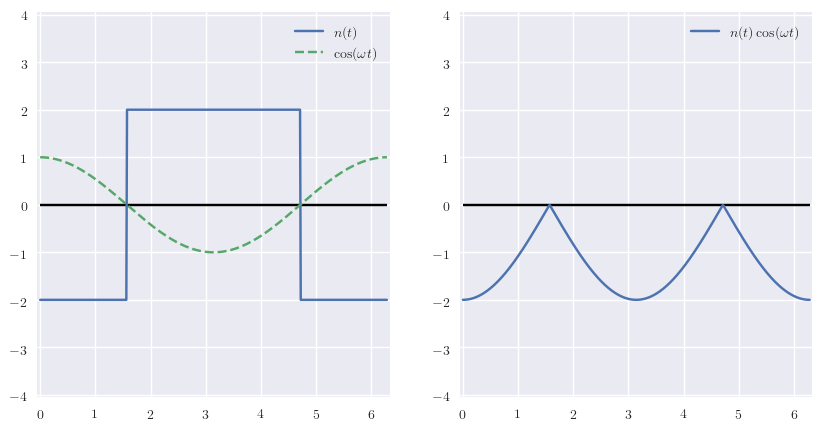

In [142]:
fig = mp.figure(figsize=(5*2, 5))

ax = fig.add_subplot(121)
ax.plot(xout, yout, label=r"$n(t)$")
ax.hlines(0, xout.min(), xout.max())
ax.set_ylim(-4.05, 4.05)
ax.set_xlim(-0.05, 2*np.pi + 0.05)
x = np.linspace(0, 2*np.pi, 500)
y = np.cos(x)
ax.plot(x, y, "--", label=r"$\cos(\omega t)$")
ax.legend()

ax = fig.add_subplot(122)
ax.plot(x, yout*y, label=r"$n(t)\cos(\omega t)$")
ax.hlines(0, xout.min(), xout.max())
ax.set_ylim(-4.05, 4.05)
ax.set_xlim(-0.05, 2*np.pi + 0.05)
ax.legend()

mp.savefig("LE3_prod-ncos.png", dpi=300, bbox_inches="tight")
mp.show()

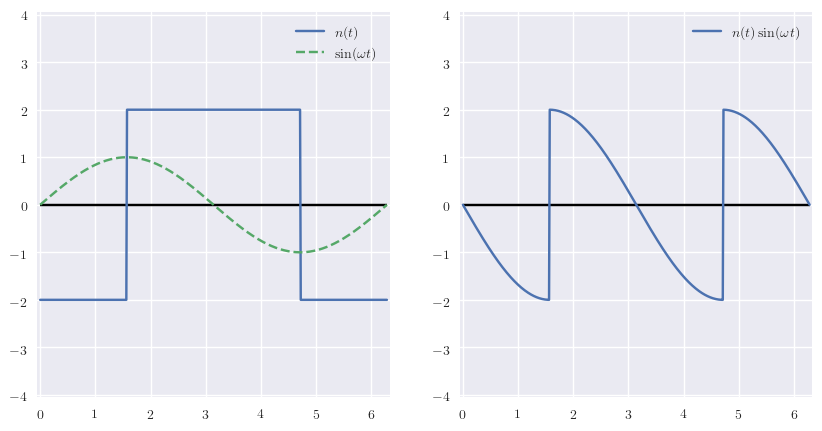

In [143]:
fig = mp.figure(figsize=(5*2, 5))

ax = fig.add_subplot(121)
ax.plot(xout, yout, label=r"$n(t)$")
ax.hlines(0, xout.min(), xout.max())
ax.set_ylim(-4.05, 4.05)
ax.set_xlim(-0.05, 2*np.pi + 0.05)
x = np.linspace(0, 2*np.pi, 500)
y = np.sin(x)
ax.plot(x, y, "--", label=r"$\sin(\omega t)$")
ax.legend()

ax = fig.add_subplot(122)
ax.plot(x, yout*y, label=r"$n(t)\sin(\omega t)$")
ax.hlines(0, xout.min(), xout.max())
ax.set_ylim(-4.05, 4.05)
ax.set_xlim(-0.05, 2*np.pi + 0.05)
ax.legend()

mp.savefig("LE3_prod-nsin.png", dpi=300, bbox_inches="tight")
mp.show()

In [15]:
G = lambda s: 3/(2*s**2 + 5*s + 6)

w = np.logspace(-1, 2, 500)
sys = LeadCompensator(w)
sys.initTransferFunc(G)
sys.initNegativeFeedback(1)
sys.initDesired(0.10, 0.1)
sys.initCompensator()

In [18]:
sys.K

2030.2997032927376